In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

import pandas as pd
import numpy as np
import cvxpy as cp
import pypfopt
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import EfficientFrontier
from pypfopt import objective_functions
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import HRPOpt
from pypfopt import CLA
from pypfopt import black_litterman
from pypfopt import BlackLittermanModel
from pypfopt import plotting


In [2]:
!pip install yfinance

  Using cached yfinance-0.1.59-py2.py3-none-any.whl
  Using cached multitasking-0.0.9-py3-none-any.whl


In [70]:
tickers = ["SPY", "GME", "AMC", "TSLA", "BB", "NVDA", "BBBY", "MVIS", "BABA", "AMD","BTC-USD","BCH","ETH","ETC","LTC","XRP","DOGE-USD"]
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%***********************]  17 of 17 completed


,AMC,AMD,BABA,BB,BBBY,BCH,BTC-USD,DOGE-USD,ETC,ETH,GME,LTC,MVIS,NVDA,SPY,TSLA,XRP
Date,,,,,,,,,,,,,,,,,
2021-05-22,NaN,NaN,NaN,NaN,NaN,NaN,37536.632812,0.342371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-23,NaN,NaN,NaN,NaN,NaN,NaN,34770.582031,0.308071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-24,13.68,77.440002,210.440002,8.62,23.75,19.040001,38705.980469,0.366162,NaN,27.719999,180.009995,39.450001,14.33,624.479980,419.170013,606.440002,NaN
2021-05-25,16.41,77.860001,211.130005,8.59,23.74,18.700001,NaN,NaN,NaN,27.430000,209.429993,39.360001,15.63,625.909973,418.239990,604.690002,NaN
2021-05-26,NaN,NaN,NaN,NaN,NaN,NaN,38729.816406,0.349866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
prices

,AMC,AMD,BABA,BB,BBBY,BCH,BTC-USD,DOGE-USD,ETC,ETH,GME,LTC,MVIS,NVDA,SPY,TSLA,XRP
Date,,,,,,,,,,,,,,,,,
2017-08-01,16.469416,13.710000,154.729996,9.51,26.660824,26.135265,2718.260010,0.001792,34.5,25.343952,17.939491,41.434288,2.25,162.812164,230.738785,63.914001,NaN
2017-08-02,12.035346,13.370000,151.910004,9.50,26.421677,26.199078,2710.669922,0.001788,34.5,24.873169,17.956287,40.776981,2.31,162.713196,230.850769,65.178001,NaN
2017-08-03,11.956165,13.240000,153.320007,9.42,27.050552,26.217310,2804.729980,0.001795,34.5,24.559311,18.191450,41.434288,2.45,164.781860,230.402954,69.417999,NaN
2017-08-04,12.866735,13.120000,153.330002,9.44,26.660824,26.372280,2895.889893,0.001820,34.5,25.147793,18.418217,41.223305,2.47,165.504440,230.822754,71.382004,NaN
2017-08-05,NaN,NaN,NaN,NaN,NaN,NaN,3252.909912,0.002087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-22,NaN,NaN,NaN,NaN,NaN,NaN,37536.632812,0.342371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-23,NaN,NaN,NaN,NaN,NaN,NaN,34770.582031,0.308071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-24,13.680000,77.440002,210.440002,8.62,23.750000,19.040001,38705.980469,0.366162,NaN,27.719999,180.009995,39.450001,14.33,624.479980,419.170013,606.440002,NaN


In [72]:
prices = prices[prices.index >= "2017-08-01"]

In [73]:
prices.to_csv("stock_prices.csv")

In [76]:
# Reading in the data; preparing expected returns and a risk model
df = pd.read_csv("stock_prices.csv", parse_dates=False, index_col="Date")
returns = df.pct_change().dropna()
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)


# Now try with a nonconvex objective from  Kolm et al (2014)
def deviation_risk_parity(w, cov_matrix):
    diff = w * np.dot(cov_matrix, w) - (w * np.dot(cov_matrix, w)).reshape(-1, 1)
    return (diff ** 2).sum().sum()

cleaned_weights = ef.clean_weights()
print(cleaned_weights)

ef = EfficientFrontier(mu, S)
weights = ef.nonconvex_objective(deviation_risk_parity, ef.cov_matrix)
ef.portfolio_performance(verbose=True)


C:\Users\hyunt\anaconda3\envs\PyPortfolioOpt\lib\site-packages\pypfopt\risk_models.py:69: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  "The covariance matrix is non positive semidefinite. Amending eigenvalues."


LinAlgError: Eigenvalues did not converge

In [66]:
# Black-Litterman
spy_prices = pd.read_csv(
    "spy_prices.csv", parse_dates=True, index_col=0, squeeze=True
)
delta = black_litterman.market_implied_risk_aversion(spy_prices)

mcaps = {
    "GOOG": 927e9,
    "AAPL": 1.19e12,
    "FB": 574e9,
    "BABA": 533e9,
    "AMZN": 867e9,
    "GE": 96e9,
    "AMD": 43e9,
    "WMT": 339e9,
    "BAC": 301e9,
    "GM": 51e9,
    "T": 61e9,
    "UAA": 78e9,
    "SHLD": 0,
    "XOM": 295e9,
    "RRC": 1e9,
    "BBY": 22e9,
    "MA": 288e9,
    "PFE": 212e9,
    "JPM": 422e9,
    "SBUX": 102e9,
}
prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)

# 1. SBUX will drop by 20%
# 2. GOOG outperforms FB by 10%
# 3. BAC and JPM will outperform T and GE by 15%
views = np.array([-0.20, 0.10, 0.15]).reshape(-1, 1)
picking = np.array(
    [
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, -0.5, 0, 0, 0.5, 0, -0.5, 0, 0, 0, 0, 0, 0, 0, 0.5, 0],
    ]
)
bl = BlackLittermanModel(S, Q=views, P=picking, pi=prior, tau=0.01)
rets = bl.bl_returns()
ef = EfficientFrontier(rets, S)
ef.max_sharpe()
print(ef.clean_weights())
ef.portfolio_performance(verbose=True)


ValueError: matrices are not aligned

In [16]:
!pip install pulp

In [20]:
!pip install cvxopt

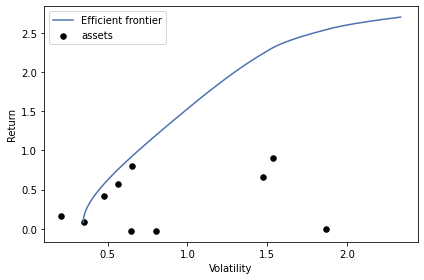

In [53]:
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.add_constraint(lambda w: w[0] >= 0.2)
ef.add_constraint(lambda w: w[2] == 0.15)
ef.add_constraint(lambda w: w[3] + w[4] <= 0.10)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()

In [52]:
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

In [57]:
pypfopt.plotting.plot_covariance(cov_matrix, plot_correlation=False, show_tickers=True, **kwargs)

NameError: name 'cov_matrix' is not defined

In [27]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
import collections
import numpy as np
import pandas as pd
import cvxpy as cp

In [30]:
def get_latest_prices(prices):
    """
    A helper tool which retrieves the most recent asset prices from a dataframe of
    asset prices, required in order to generate a discrete allocation.

    :param prices: historical asset prices
    :type prices: pd.DataFrame
    :raises TypeError: if prices are not in a dataframe
    :return: the most recent price of each asset
    :rtype: pd.Series
    """
    if not isinstance(prices, pd.DataFrame):
        raise TypeError("prices not in a dataframe")
    return prices.ffill().iloc[-1]


class DiscreteAllocation:
    """
    Generate a discrete portfolio allocation from continuous weights

    Instance variables:

    - Inputs:

        - ``weights`` - dict
        - ``latest_prices`` - pd.Series or dict
        - ``total_portfolio_value`` - int/float
        - ``short_ratio``- float

    - Output: ``allocation`` - dict

    Public methods:

    - ``greedy_portfolio()`` - uses a greedy algorithm
    - ``lp_portfolio()`` - uses linear programming
    """

    def __init__(
        self, weights, latest_prices, total_portfolio_value=10000, short_ratio=None
    ):
        """
        :param weights: continuous weights generated from the ``efficient_frontier`` module
        :type weights: dict
        :param latest_prices: the most recent price for each asset
        :type latest_prices: pd.Series
        :param total_portfolio_value: the desired total value of the portfolio, defaults to 10000
        :type total_portfolio_value: int/float, optional
        :param short_ratio: the short ratio, e.g 0.3 corresponds to 130/30. If None,
                            defaults to the input weights.
        :type short_ratio: float, defaults to None.
        :raises TypeError: if ``weights`` is not a dict
        :raises TypeError: if ``latest_prices`` isn't a series
        :raises ValueError: if ``short_ratio < 0``
        """
        if not isinstance(weights, dict):
            raise TypeError("weights should be a dictionary of {ticker: weight}")
        if any(np.isnan(val) for val in weights.values()):
            raise ValueError("weights should have no NaNs")
        if (not isinstance(latest_prices, pd.Series)) or any(np.isnan(latest_prices)):
            raise TypeError("latest_prices should be a pd.Series with no NaNs")
        if total_portfolio_value <= 0:
            raise ValueError("total_portfolio_value must be greater than zero")
        if short_ratio is not None and short_ratio < 0:
            raise ValueError("short_ratio must be non-negative")

        # Drop any companies with negligible weights. Use a tuple because order matters.
        self.weights = list(weights.items())
        self.latest_prices = latest_prices
        self.total_portfolio_value = total_portfolio_value
        if short_ratio is None:
            self.short_ratio = sum((-x[1] for x in self.weights if x[1] < 0))
        else:
            self.short_ratio = short_ratio


    @staticmethod
    def _remove_zero_positions(allocation):
        """
        Utility function to remove zero positions (i.e with no shares being bought)

        :type allocation: dict
        """
        return {k: v for k, v in allocation.items() if v != 0}


    def _allocation_rmse_error(self, verbose=True):
        """
        Utility function to calculate and print RMSE error between discretised
        weights and continuous weights. RMSE was used instead of MAE because we
        want to penalise large variations.

        :param verbose: print weight discrepancies?
        :type verbose: bool
        :return: rmse error
        :rtype: float
        """
        portfolio_val = 0
        for ticker, num in self.allocation.items():
            portfolio_val += num * self.latest_prices[ticker]

        sse = 0  # sum of square errors
        for ticker, weight in self.weights:
            if ticker in self.allocation:
                allocation_weight = (
                    self.allocation[ticker] * self.latest_prices[ticker] / portfolio_val
                )
            else:
                allocation_weight = 0
            sse += (weight - allocation_weight) ** 2
            if verbose:
                print(
                    "{}: allocated {:.3f}, desired {:.3f}".format(
                        ticker, allocation_weight, weight
                    )
                )
        rmse = np.sqrt(sse / len(self.weights))
        print("Allocation has RMSE: {:.3f}".format(rmse))
        return rmse


    def greedy_portfolio(self, reinvest=False, verbose=False):
        """
        Convert continuous weights into a discrete portfolio allocation
        using a greedy iterative approach.

        :param reinvest: whether or not to reinvest cash gained from shorting
        :type reinvest: bool, defaults to False
        :param verbose: print error analysis?
        :type verbose: bool, defaults to False
        :return: the number of shares of each ticker that should be purchased,
                 along with the amount of funds leftover.
        :rtype: (dict, float)
        """
        # Sort in descending order of weight
        self.weights.sort(key=lambda x: x[1], reverse=True)

        # If portfolio contains shorts
        if self.weights[-1][1] < 0:
            longs = {t: w for t, w in self.weights if w >= 0}
            shorts = {t: -w for t, w in self.weights if w < 0}

            # Make them sum to one
            long_total_weight = sum(longs.values())
            short_total_weight = sum(shorts.values())
            longs = {t: w / long_total_weight for t, w in longs.items()}
            shorts = {t: w / short_total_weight for t, w in shorts.items()}

            # Construct long-only discrete allocations for each
            short_val = self.total_portfolio_value * self.short_ratio
            long_val = self.total_portfolio_value
            if reinvest:
                long_val += short_val

            if verbose:
                print("\nAllocating long sub-portfolio...")
            da1 = DiscreteAllocation(
                longs, self.latest_prices[longs.keys()], total_portfolio_value=long_val
            )
            long_alloc, long_leftover = da1.greedy_portfolio()

            if verbose:
                print("\nAllocating short sub-portfolio...")
            da2 = DiscreteAllocation(
                shorts,
                self.latest_prices[shorts.keys()],
                total_portfolio_value=short_val,
            )
            short_alloc, short_leftover = da2.greedy_portfolio()
            short_alloc = {t: -w for t, w in short_alloc.items()}

            # Combine and return
            self.allocation = long_alloc.copy()
            self.allocation.update(short_alloc)
            self.allocation = self._remove_zero_positions(self.allocation)

            return self.allocation, long_leftover + short_leftover

        # Otherwise, portfolio is long only and we proceed with greedy algo
        available_funds = self.total_portfolio_value
        shares_bought = []
        buy_prices = []

        # First round
        for ticker, weight in self.weights:
            price = self.latest_prices[ticker]
            # Attempt to buy the lower integer number of shares, which could be zero.
            n_shares = int(weight * self.total_portfolio_value / price)
            cost = n_shares * price
            # As weights are all > 0 (long only) we always round down n_shares
            # so the cost is always <= simple weighted share of portfolio value,
            # so we can not run out of funds just here.
            assert cost <= available_funds, "Unexpectedly insufficient funds."
            available_funds -= cost
            shares_bought.append(n_shares)
            buy_prices.append(price)

        # Second round
        while available_funds > 0:
            # Calculate the equivalent continuous weights of the shares that
            # have already been bought
            current_weights = np.array(buy_prices) * np.array(shares_bought)
            current_weights /= current_weights.sum()
            ideal_weights = np.array([i[1] for i in self.weights])
            deficit = ideal_weights - current_weights

            # Attempt to buy the asset whose current weights deviate the most
            idx = np.argmax(deficit)
            ticker, weight = self.weights[idx]
            price = self.latest_prices[ticker]

            # If we can't afford this asset, search for the next highest deficit that we
            # can purchase.
            counter = 0
            while price > available_funds:
                deficit[idx] = 0  # we can no longer purchase the asset at idx
                idx = np.argmax(deficit)  # find the next most deviant asset

                # If either of these conditions is met, we break out of both while loops
                # hence the repeated statement below
                if deficit[idx] < 0 or counter == 10:
                    break

                ticker, weight = self.weights[idx]
                price = self.latest_prices[ticker]
                counter += 1

            if deficit[idx] <= 0 or counter == 10:  # pragma: no cover
                # Dirty solution to break out of both loops
                break

            # Buy one share at a time
            shares_bought[idx] += 1
            available_funds -= price

        self.allocation = self._remove_zero_positions(
            collections.OrderedDict(zip([i[0] for i in self.weights], shares_bought))
        )

        if verbose:
            print("Funds remaining: {:.2f}".format(available_funds))
            self._allocation_rmse_error(verbose)
        return self.allocation, available_funds


    def lp_portfolio(self, reinvest=False, verbose=False, solver="GLPK_MI"):
        """
        Convert continuous weights into a discrete portfolio allocation
        using integer programming.

        :param reinvest: whether or not to reinvest cash gained from shorting
        :type reinvest: bool, defaults to False
        :param verbose: print error analysis?
        :type verbose: bool
        :param solver: the CVXPY solver to use (must support mixed-integer programs)
        :type solver: str, defaults to "GLPK_MI"
        :return: the number of shares of each ticker that should be purchased, along with the amount
                of funds leftover.
        :rtype: (dict, float)
        """
        if any([w < 0 for _, w in self.weights]):
            longs = {t: w for t, w in self.weights if w >= 0}
            shorts = {t: -w for t, w in self.weights if w < 0}

            # Make them sum to one
            long_total_weight = sum(longs.values())
            short_total_weight = sum(shorts.values())
            longs = {t: w / long_total_weight for t, w in longs.items()}
            shorts = {t: w / short_total_weight for t, w in shorts.items()}

            # Construct long-only discrete allocations for each
            short_val = self.total_portfolio_value * self.short_ratio
            long_val = self.total_portfolio_value
            if reinvest:
                long_val += short_val

            if verbose:
                print("\nAllocating long sub-portfolio:")
            da1 = DiscreteAllocation(
                longs, self.latest_prices[longs.keys()], total_portfolio_value=long_val
            )
            long_alloc, long_leftover = da1.lp_portfolio()

            if verbose:
                print("\nAllocating short sub-portfolio:")
            da2 = DiscreteAllocation(
                shorts,
                self.latest_prices[shorts.keys()],
                total_portfolio_value=short_val,
            )
            short_alloc, short_leftover = da2.lp_portfolio()
            short_alloc = {t: -w for t, w in short_alloc.items()}

            # Combine and return
            self.allocation = long_alloc.copy()
            self.allocation.update(short_alloc)
            self.allocation = self._remove_zero_positions(self.allocation)
            return self.allocation, long_leftover + short_leftover

        p = self.latest_prices.values
        n = len(p)
        w = np.fromiter([i[1] for i in self.weights], dtype=float)

        # Integer allocation
        x = cp.Variable(n, integer=True)
        # Remaining dollars
        r = self.total_portfolio_value - p.T @ x

        # Set up linear program
        eta = w * self.total_portfolio_value - cp.multiply(x, p)
        u = cp.Variable(n)
        constraints = [eta <= u, eta >= -u, x >= 0, r >= 0]
        objective = cp.sum(u) + r

        opt = cp.Problem(cp.Minimize(objective), constraints)

        if solver is not None and solver not in cp.installed_solvers():
            raise NameError("Solver {} is not installed. ".format(solver))
        opt.solve(solver=solver)

        if opt.status not in {"optimal", "optimal_inaccurate"}:  # pragma: no cover
            raise exceptions.OptimizationError("Please try greedy_portfolio")

        vals = np.rint(x.value).astype(int)
        self.allocation = self._remove_zero_positions(
            collections.OrderedDict(zip([i[0] for i in self.weights], vals))
        )

        if verbose:
            print("Funds remaining: {:.2f}".format(r.value))
            self._allocation_rmse_error()
        return self.allocation, r.value

<class '__main__.DiscreteAllocation'>


In [28]:
portfolio_val = 5000
latest_prices = get_latest_prices(df)
weights = cleaned_weights
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value = portfolio_val)
allocation, leftover = da.lp_portfolio()
print('Discrete allocation:', allocation)
print('Funds Remaining: $', leftover)

SolverError: The solver GLPK_MI is not installed.

NameError: name 'cvxpy' is not defined